In [16]:
#import required libraries and functions
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# import ccomplete_bikeshare_with_bar_count_df dataframe .pkl file
omplete_bikeshare_with_bar_count_df = pd.read_pickle("complete_bikeshare_with_bar_count_df.pkl")
# Optional: check to ensure file dataframe loaded
complete_bikeshare_with_bar_count_df.head(3)

,id,bar_count,"2024-02-09, 17:00:00","2024-02-09, 18:00:00","2024-02-09, 19:00:00","2024-02-09, 20:00:00","2024-02-09, 21:00:00","2024-02-09, 22:00:00","2024-02-10, 00:00:00","2024-02-10, 01:00:00","2024-02-10, 02:00:00","2024-02-10, 03:00:00"
0,7a19c49f486d7c0c02b3685d7b240448,0.0,0.222222,0.083333,0.027778,0.055556,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778
1,32603a87cfca71d0f7dfa3513bad69d5,9.0,0.812500,0.625000,0.687500,0.625000,0.562500,0.562500,0.500000,0.500000,0.562500,0.562500
2,6d42fa40360f9a6b2bf641c7b8bb2862,8.0,0.307692,0.307692,0.153846,0.153846,0.230769,0.230769,0.192308,0.192308,0.192308,0.192308


**Two-way time series ANOVA**

In [5]:
# reshape the df for two-way time series ANOVA
df_melted = pd.melt(
    complete_bikeshare_with_bar_count_df,
    id_vars=['id', 'bar_count'],
    var_name='timestamp',
    value_name='available_bikes'
)

# convert timestamp column to datetime 
df_melted['timestamp'] = pd.to_datetime(df_melted['timestamp'])

# perform two-way timeseries ANOVA using statsmodels function
model = ols('available_bikes ~ C(bar_count) + C(timestamp)', data=df_melted).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# print table
print(anova_table)

                  sum_sq      df         F        PR(>F)
C(bar_count)    4.818087    10.0  8.434349  1.255956e-13
C(timestamp)    0.089767     9.0  0.174603  9.965668e-01
Residual      140.526502  2460.0       NaN           NaN


**ANOVA Table Results:**

Timestamp:
The p-value = 0.9965668 (>0.05) 
This suggests that 'timestamp' does not have a significant effect on the number of available bikes.


Bar count:
The p-value = 1.26e-13 (<0.05) 
This suggests that bar count has a significant effect on the number of available bikes.





**Regression Analysis and Scatterplots for Time Series**

In [9]:
#define time series columns
time_columns = [col for col in complete_bikeshare_with_bar_count_df.columns if col not in ['id', 'bar_count']]

# reshape dataframe
df_long = pd.melt(complete_bikeshare_with_bar_count_df, id_vars=['id', 'bar_count'], value_vars=time_columns,
                  var_name='time_point', value_name='bikes_available')

# extract timestamp from the 'time_point' column
df_long['timestamp'] = pd.to_datetime(df_long['time_point'], format='%Y-%m-%d, %H:%M:%S')
# extract hour from the timestamp
df_long['hour'] = df_long['timestamp'].dt.hour

# add constant
X = sm.add_constant(df_long[['hour']])

# create regression model using statsmodels function
model = sm.OLS(df_long['bikes_available'], X).fit()

#print regression statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        bikes_available   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5929
Date:                Mon, 12 Feb 2024   Prob (F-statistic):              0.441
Time:                        22:50:27   Log-Likelihood:                -1.6725
No. Observations:                2480   AIC:                             7.345
Df Residuals:                    2478   BIC:                             18.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4476      0.008     54.118      0.0

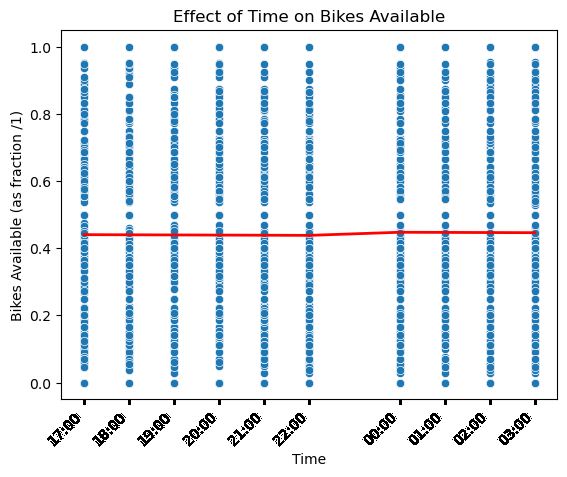

In [17]:
# plot scatter plot
sns.scatterplot(x='timestamp', y='bikes_available', data=df_long)

# Plot the regression line
plt.plot(df_long['timestamp'], model.predict(X), color='red', linewidth=2)

# set x-axis labels to only display the hour
plt.xticks(df_long['timestamp'], [hour.strftime('%H:%M') for hour in df_long['timestamp']], rotation=45, ha='right')
# add labels and title
plt.xlabel('Time')
plt.ylabel('Bikes Available (as fraction /1)')
plt.title('Effect of Time on Bikes Available')

# save plot as image
plt.savefig('effect_of_time_on_bike_availability_plot.png', bbox_inches='tight')

# show plot
plt.show()

**Regression Analysis Results for Time:**

R-squared & Adj. R-squared : value is 0.000!
So no explanatory power.


**Regression Analysis and Scatterplots for Bar Count**

In [7]:
# reshape the dataframe to have a separate row for each observation
df_long = pd.melt(complete_bikeshare_with_bar_count_df, id_vars=['id', 'bar_count'], 
                  var_name='time_point', value_name='bikes_available')

# add constant using statsmodels
X = sm.add_constant(df_long[['bar_count']])

# create regression model using statsmodels function
model = sm.OLS(df_long['bikes_available'], X).fit()

# print regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        bikes_available   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     15.84
Date:                Mon, 12 Feb 2024   Prob (F-statistic):           7.07e-05
Time:                        22:48:03   Log-Likelihood:                 5.9341
No. Observations:                2480   AIC:                            -7.868
Df Residuals:                    2478   BIC:                             3.764
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4267      0.006     68.290      0.0

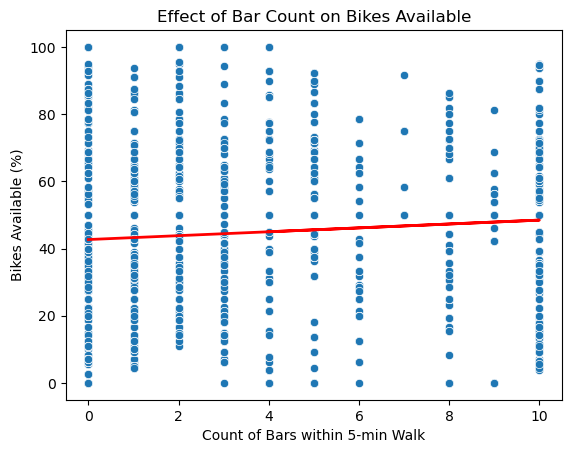

In [5]:
# convert 'bikes_available' to percentage
df_long['bikes_available_percentage'] = df_long['bikes_available'] * 100

# scatter plot
sns.scatterplot(x='bar_count', y='bikes_available_percentage', data=df_long)

# plot regression line
plt.plot(df_long['bar_count'], model.predict(X) * 100, color='red', linewidth=2)

# add labels and title
plt.xlabel('Count of Bars within 5-min Walk')
plt.ylabel('Bikes Available (%)')
plt.title('Effect of Bar Count on Bikes Available')

# save plot as image
plt.savefig('effect_of_bar_count_on_bike_availability_plot.png', bbox_inches='tight')

# show plot
plt.show()

**Regression Analysis Results for Bar Count:**

Slope: The estimated coefficient = 0.0058. 
Represents the expected change available bikes for a one-unit increase in bar count.

P-value: < 0.05 (0.000), indicating that the effect of 'bar_count' on 'bikes_available' is statistically significant.

R-squared & Adj. R-squared : value is 0.006
This indicates that approximately 0.6% of the variance in available bikes is explained by bar count. 
This is a very weak explanatory power.


**Bar Count Box Plot**

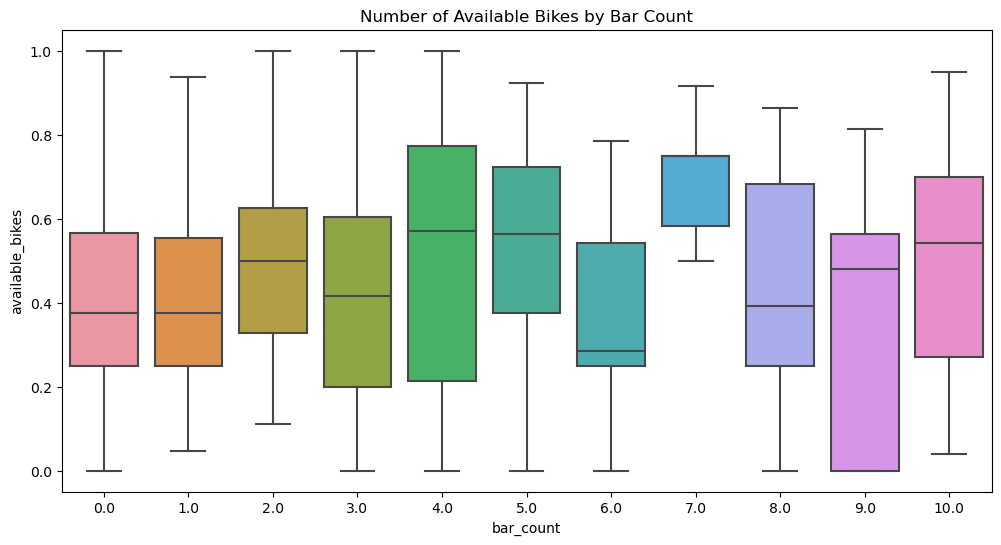

<Figure size 640x480 with 0 Axes>

In [15]:
# use seaborn and matplotlib functions to create boxplot for bar count
#define figure size
plt.figure(figsize=(12, 6))

#create boxplot and axis lables
sns.boxplot(x='bar_count', y='available_bikes', data=df_melted)

#add title
plt.title('Number of Available Bikes by Bar Count')

# save the plot as image
plt.savefig('number_of available_bikes_by_bar_count.png', bbox_inches='tight')

#show plot
plt.show()


# Stretch

How can you turn the regression model into a classification model?

The model could be turned into a classification model by comparing bikes available at locations with bars vs without bars.